In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=100 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cl_orig = target_df.iloc[:,4].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cl = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [27]:
y = cl.reshape((-1,1))

In [28]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [29]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 100)   500         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 100)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2700)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [35]:
ckpt_name = model_directory + "20221130steadyValidation_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_Clcheckpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 15s - loss: 0.4675 - rmse: 0.6837
Epoch 1: val_loss improved from inf to 0.38857, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 4s 137ms/step - loss: 0.3934 - rmse: 0.6272 - val_loss: 0.3886 - val_rmse: 0.6234 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.3134 - rmse: 0.5598
Epoch 2: val_loss improved from 0.38857 to 0.34519, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 50ms/step - loss: 0.3513 - rmse: 0.5927 - val_loss: 0.3452 - val_rmse: 0.5875 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.2282 - rmse: 0.4777
Epoch 3: val_loss improved from 0.34519 to 0.29717, saving model to D:\TrainedModels\20

1/5 [=====>........................] - ETA: 0s - loss: 0.0580 - rmse: 0.2409
Epoch 22: val_loss improved from 0.04094 to 0.03971, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 0.0459 - rmse: 0.2143 - val_loss: 0.0397 - val_rmse: 0.1993 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0458 - rmse: 0.2140
Epoch 23: val_loss improved from 0.03971 to 0.03809, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 0.0441 - rmse: 0.2099 - val_loss: 0.0381 - val_rmse: 0.1952 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0493 - rmse: 0.2219
Epoch 24: val_loss improved from 0.03809 to 0.03618, saving model to D:\TrainedModels\202211302

1/5 [=====>........................] - ETA: 0s - loss: 0.0157 - rmse: 0.1251
Epoch 42: val_loss improved from 0.01141 to 0.01024, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 34ms/step - loss: 0.0110 - rmse: 0.1047 - val_loss: 0.0102 - val_rmse: 0.1012 - lr: 1.0000e-04
Epoch 43/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0111 - rmse: 0.1052
Epoch 43: val_loss improved from 0.01024 to 0.00970, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0106 - rmse: 0.1029 - val_loss: 0.0097 - val_rmse: 0.0985 - lr: 1.0000e-04
Epoch 44/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0071 - rmse: 0.0842
Epoch 44: val_loss improved from 0.00970 to 0.00949, saving model to D:\TrainedModels\202211302

1/5 [=====>........................] - ETA: 0s - loss: 0.0185 - rmse: 0.1361
Epoch 65: val_loss did not improve from 0.00734
5/5 [==============================] - 0s 13ms/step - loss: 0.0079 - rmse: 0.0891 - val_loss: 0.0075 - val_rmse: 0.0865 - lr: 1.0000e-04
Epoch 66/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0058 - rmse: 0.0764
Epoch 66: val_loss did not improve from 0.00734
5/5 [==============================] - 0s 13ms/step - loss: 0.0077 - rmse: 0.0875 - val_loss: 0.0073 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 67/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 67: val_loss did not improve from 0.00734
5/5 [==============================] - 0s 14ms/step - loss: 0.0077 - rmse: 0.0876 - val_loss: 0.0076 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 68/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0103 - rmse: 0.1013
Epoch 68: val_loss did not improve from 0.00734
5/5 [==============================] - 0s 14

1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0558
Epoch 91: val_loss did not improve from 0.00687
5/5 [==============================] - 0s 14ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0071 - val_rmse: 0.0841 - lr: 1.0000e-04
Epoch 92/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0100 - rmse: 0.1000
Epoch 92: val_loss did not improve from 0.00687
5/5 [==============================] - 0s 14ms/step - loss: 0.0074 - rmse: 0.0861 - val_loss: 0.0069 - val_rmse: 0.0831 - lr: 1.0000e-04
Epoch 93/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.9111e-04 - rmse: 0.0315
Epoch 93: val_loss did not improve from 0.00687
5/5 [==============================] - 0s 14ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0070 - val_rmse: 0.0836 - lr: 1.0000e-04
Epoch 94/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0802
Epoch 94: val_loss did not improve from 0.00687
5/5 [==============================] - 0

1/5 [=====>........................] - ETA: 0s - loss: 0.0144 - rmse: 0.1199
Epoch 117: val_loss did not improve from 0.00661
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - rmse: 0.0848 - val_loss: 0.0067 - val_rmse: 0.0820 - lr: 1.0000e-04
Epoch 118/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0042 - rmse: 0.0645
Epoch 118: val_loss did not improve from 0.00661
5/5 [==============================] - 0s 15ms/step - loss: 0.0070 - rmse: 0.0839 - val_loss: 0.0067 - val_rmse: 0.0818 - lr: 1.0000e-04
Epoch 119/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0099 - rmse: 0.0995
Epoch 119: val_loss did not improve from 0.00661
5/5 [==============================] - 0s 14ms/step - loss: 0.0069 - rmse: 0.0832 - val_loss: 0.0068 - val_rmse: 0.0827 - lr: 1.0000e-04
Epoch 120/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0616
Epoch 120: val_loss did not improve from 0.00661
5/5 [==============================] 

Epoch 144/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 144: val_loss did not improve from 0.00638
5/5 [==============================] - 0s 14ms/step - loss: 0.0069 - rmse: 0.0831 - val_loss: 0.0064 - val_rmse: 0.0800 - lr: 1.0000e-04
Epoch 145/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0064 - rmse: 0.0801
Epoch 145: val_loss did not improve from 0.00638
5/5 [==============================] - 0s 13ms/step - loss: 0.0068 - rmse: 0.0822 - val_loss: 0.0065 - val_rmse: 0.0809 - lr: 1.0000e-04
Epoch 146/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0565
Epoch 146: val_loss did not improve from 0.00638
5/5 [==============================] - 0s 14ms/step - loss: 0.0067 - rmse: 0.0821 - val_loss: 0.0069 - val_rmse: 0.0833 - lr: 1.0000e-04
Epoch 147/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0065 - rmse: 0.0806
Epoch 147: val_loss improved from 0.00638 to 0.00637, saving model to 

5/5 [==============================] - 0s 30ms/step - loss: 0.0060 - rmse: 0.0775 - val_loss: 0.0061 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 171/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0144 - rmse: 0.1199
Epoch 171: val_loss did not improve from 0.00612
5/5 [==============================] - 0s 14ms/step - loss: 0.0063 - rmse: 0.0792 - val_loss: 0.0063 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 172/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0049 - rmse: 0.0699
Epoch 172: val_loss did not improve from 0.00612
5/5 [==============================] - 0s 13ms/step - loss: 0.0065 - rmse: 0.0804 - val_loss: 0.0062 - val_rmse: 0.0790 - lr: 1.0000e-04
Epoch 173/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0495
Epoch 173: val_loss did not improve from 0.00612
5/5 [==============================] - 0s 13ms/step - loss: 0.0066 - rmse: 0.0812 - val_loss: 0.0062 - val_rmse: 0.0791 - lr: 1.0000e-04
Epoch 174/10000
1/5 [=====

5/5 [==============================] - 0s 28ms/step - loss: 0.0057 - rmse: 0.0757 - val_loss: 0.0058 - val_rmse: 0.0762 - lr: 1.0000e-04
Epoch 198/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0055 - rmse: 0.0741
Epoch 198: val_loss did not improve from 0.00581
5/5 [==============================] - 0s 14ms/step - loss: 0.0057 - rmse: 0.0756 - val_loss: 0.0061 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 199/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0124 - rmse: 0.1112
Epoch 199: val_loss did not improve from 0.00581
5/5 [==============================] - 0s 14ms/step - loss: 0.0058 - rmse: 0.0759 - val_loss: 0.0059 - val_rmse: 0.0767 - lr: 1.0000e-04
Epoch 200/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0082 - rmse: 0.0903
Epoch 200: val_loss did not improve from 0.00581
5/5 [==============================] - 0s 14ms/step - loss: 0.0057 - rmse: 0.0755 - val_loss: 0.0060 - val_rmse: 0.0775 - lr: 1.0000e-04
Epoch 201/10000
1/5 [=====

Epoch 223/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - rmse: 0.0687
Epoch 223: val_loss did not improve from 0.00545
5/5 [==============================] - 0s 14ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0060 - val_rmse: 0.0773 - lr: 1.0000e-04
Epoch 224/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0559
Epoch 224: val_loss did not improve from 0.00545
5/5 [==============================] - 0s 14ms/step - loss: 0.0054 - rmse: 0.0734 - val_loss: 0.0055 - val_rmse: 0.0743 - lr: 1.0000e-04
Epoch 225/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0030 - rmse: 0.0548
Epoch 225: val_loss improved from 0.00545 to 0.00540, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 0.0051 - rmse: 0.0716 - val_loss: 0.0054 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 226/10000
1/5 [=====

5/5 [==============================] - 0s 28ms/step - loss: 0.0049 - rmse: 0.0698 - val_loss: 0.0050 - val_rmse: 0.0709 - lr: 1.0000e-04
Epoch 249/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0074 - rmse: 0.0861
Epoch 249: val_loss did not improve from 0.00503
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0674 - val_loss: 0.0050 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 250/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 250: val_loss did not improve from 0.00503
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - rmse: 0.0671 - val_loss: 0.0051 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 251/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 251: val_loss improved from 0.00503 to 0.00499, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [=====================

Epoch 273/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6727e-04 - rmse: 0.0294
Epoch 273: val_loss improved from 0.00458 to 0.00448, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 0.0040 - rmse: 0.0632 - val_loss: 0.0045 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 274/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0037 - rmse: 0.0609
Epoch 274: val_loss did not improve from 0.00448
5/5 [==============================] - 0s 14ms/step - loss: 0.0041 - rmse: 0.0643 - val_loss: 0.0049 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 275/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0044 - rmse: 0.0665
Epoch 275: val_loss did not improve from 0.00448
5/5 [==============================] - 0s 14ms/step - loss: 0.0040 - rmse: 0.0630 - val_loss: 0.0046 - val_rmse: 0.0681 - lr: 1.0000e-04
Epoch 276/10000
1/5 [=

5/5 [==============================] - 0s 30ms/step - loss: 0.0034 - rmse: 0.0582 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 298/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - rmse: 0.0689
Epoch 298: val_loss did not improve from 0.00395
5/5 [==============================] - 0s 14ms/step - loss: 0.0035 - rmse: 0.0591 - val_loss: 0.0040 - val_rmse: 0.0632 - lr: 1.0000e-04
Epoch 299/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0439
Epoch 299: val_loss improved from 0.00395 to 0.00387, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 28ms/step - loss: 0.0032 - rmse: 0.0569 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 300/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0352
Epoch 300: val_loss did not improve from 0.00387
5/5 [=====================

5/5 [==============================] - 0s 28ms/step - loss: 0.0027 - rmse: 0.0521 - val_loss: 0.0032 - val_rmse: 0.0564 - lr: 1.0000e-04
Epoch 323/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 323: val_loss improved from 0.00319 to 0.00311, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 30ms/step - loss: 0.0027 - rmse: 0.0523 - val_loss: 0.0031 - val_rmse: 0.0558 - lr: 1.0000e-04
Epoch 324/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0508
Epoch 324: val_loss improved from 0.00311 to 0.00309, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 30ms/step - loss: 0.0024 - rmse: 0.0491 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 325/10000
1/5 [=====>....

Epoch 348/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0040 - rmse: 0.0632
Epoch 348: val_loss did not improve from 0.00249
5/5 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0472 - val_loss: 0.0029 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 349/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0033 - rmse: 0.0574
Epoch 349: val_loss did not improve from 0.00249
5/5 [==============================] - 0s 14ms/step - loss: 0.0022 - rmse: 0.0471 - val_loss: 0.0025 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 350/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 350: val_loss improved from 0.00249 to 0.00229, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 78ms/step - loss: 0.0019 - rmse: 0.0433 - val_loss: 0.0023 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 351/10000
1/5 [=====

5/5 [==============================] - 0s 30ms/step - loss: 0.0013 - rmse: 0.0367 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 374/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0469
Epoch 374: val_loss did not improve from 0.00166
5/5 [==============================] - 0s 14ms/step - loss: 0.0013 - rmse: 0.0363 - val_loss: 0.0018 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 375/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7485e-04 - rmse: 0.0194
Epoch 375: val_loss improved from 0.00166 to 0.00157, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 376/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8973e-04 - rmse: 0.0315
Epoch 376: val_loss did not improve from 0.00157
5/5 [=============

Epoch 399/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 399: val_loss did not improve from 0.00108
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0334 - val_loss: 0.0026 - val_rmse: 0.0505 - lr: 1.0000e-04
Epoch 400/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5600e-04 - rmse: 0.0256
Epoch 400: val_loss did not improve from 0.00108
5/5 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 401/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6691e-04 - rmse: 0.0277
Epoch 401: val_loss did not improve from 0.00108
5/5 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0386 - val_loss: 0.0011 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 402/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8515e-04 - rmse: 0.0196
Epoch 402: val_loss did not improve from 0.00108
5/5 [====

1/5 [=====>........................] - ETA: 0s - loss: 3.0081e-04 - rmse: 0.0173
Epoch 424: val_loss improved from 0.00071 to 0.00070, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 33ms/step - loss: 4.1056e-04 - rmse: 0.0203 - val_loss: 7.0321e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 425/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2247e-04 - rmse: 0.0111
Epoch 425: val_loss did not improve from 0.00070
5/5 [==============================] - 0s 14ms/step - loss: 4.7611e-04 - rmse: 0.0218 - val_loss: 9.3052e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 426/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7420e-04 - rmse: 0.0132
Epoch 426: val_loss did not improve from 0.00070
5/5 [==============================] - 0s 14ms/step - loss: 5.8844e-04 - rmse: 0.0243 - val_loss: 7.4769e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 

5/5 [==============================] - 0s 27ms/step - loss: 2.5687e-04 - rmse: 0.0160 - val_loss: 4.9386e-04 - val_rmse: 0.0222 - lr: 1.0000e-04
Epoch 450/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2512e-04 - rmse: 0.0206
Epoch 450: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 13ms/step - loss: 2.5874e-04 - rmse: 0.0161 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 451/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2424e-04 - rmse: 0.0111
Epoch 451: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 14ms/step - loss: 4.9262e-04 - rmse: 0.0222 - val_loss: 5.7539e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 452/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1246e-04 - rmse: 0.0177
Epoch 452: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 14ms/step - loss: 7.1668e-04 - rmse: 0.0268 - val_loss: 9.6930e-04 - val_rmse: 0.0311 - l

Epoch 476/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3338e-05 - rmse: 0.0080
Epoch 476: val_loss improved from 0.00035 to 0.00034, saving model to D:\TrainedModels\2022113020221130steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_Clcheckpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 1.8811e-04 - rmse: 0.0137 - val_loss: 3.3603e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 477/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2499e-04 - rmse: 0.0206
Epoch 477: val_loss did not improve from 0.00034
5/5 [==============================] - 0s 14ms/step - loss: 1.8598e-04 - rmse: 0.0136 - val_loss: 3.7127e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 478/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5696e-05 - rmse: 0.0098
Epoch 478: val_loss did not improve from 0.00034
5/5 [==============================] - 0s 15ms/step - loss: 1.3804e-04 - rmse: 0.0117 - val_loss: 5.0165e-04 - val_rmse: 0.0224 - lr: 1

Epoch 503/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5139e-05 - rmse: 0.0050
Epoch 503: val_loss did not improve from 0.00027
5/5 [==============================] - 0s 14ms/step - loss: 1.2338e-04 - rmse: 0.0111 - val_loss: 2.8638e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 504/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2341e-04 - rmse: 0.0111
Epoch 504: val_loss did not improve from 0.00027
5/5 [==============================] - 0s 14ms/step - loss: 1.2698e-04 - rmse: 0.0113 - val_loss: 3.3702e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 505/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2375e-05 - rmse: 0.0096
Epoch 505: val_loss did not improve from 0.00027
5/5 [==============================] - 0s 14ms/step - loss: 1.3723e-04 - rmse: 0.0117 - val_loss: 3.4997e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 506/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1217e-05 - rmse: 0.0096
Epoch 506: val_loss did not im

Epoch 531/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8486e-05 - rmse: 0.0089
Epoch 531: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 1.1901e-04 - rmse: 0.0109 - val_loss: 2.7149e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 532/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3334e-05 - rmse: 0.0066
Epoch 532: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 7.1587e-05 - rmse: 0.0085 - val_loss: 3.0262e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 533/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2078e-05 - rmse: 0.0072
Epoch 533: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 8.6491e-05 - rmse: 0.0093 - val_loss: 2.7239e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 534/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7529e-05 - rmse: 0.0069
Epoch 534: val_loss did not im

Epoch 559/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2945e-05 - rmse: 0.0057
Epoch 559: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 5.2036e-05 - rmse: 0.0072 - val_loss: 2.9598e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 560/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7621e-05 - rmse: 0.0053
Epoch 560: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 5.9970e-05 - rmse: 0.0077 - val_loss: 2.5530e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 561/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0512e-05 - rmse: 0.0090
Epoch 561: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 14ms/step - loss: 5.5486e-05 - rmse: 0.0074 - val_loss: 2.7993e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 562/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3024e-05 - rmse: 0.0057
Epoch 562: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 6.2511e-04 - rmse: 0.0250
Epoch 586: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 4.8249e-04 - rmse: 0.0220 - val_loss: 3.7727e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 587/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4693e-04 - rmse: 0.0121
Epoch 587: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 3.4380e-04 - rmse: 0.0185 - val_loss: 8.9866e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 588/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4778e-04 - rmse: 0.0186
Epoch 588: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 14ms/step - loss: 1.8656e-04 - rmse: 0.0137 - val_loss: 2.8826e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 589/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8720e-04 - rmse: 0.0169
Epoch 589: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.9107e-05 - rmse: 0.0044
Epoch 613: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 4.5898e-05 - rmse: 0.0068 - val_loss: 2.3123e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 614/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5424e-05 - rmse: 0.0087
Epoch 614: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 5.2955e-05 - rmse: 0.0073 - val_loss: 2.7208e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 615/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6871e-05 - rmse: 0.0061
Epoch 615: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 4.2749e-05 - rmse: 0.0065 - val_loss: 2.4564e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 616/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8834e-05 - rmse: 0.0062
Epoch 616: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.8009e-05 - rmse: 0.0042
Epoch 641: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 2.7159e-05 - rmse: 0.0052 - val_loss: 1.8864e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 642/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4614e-05 - rmse: 0.0038
Epoch 642: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 4.9487e-05 - rmse: 0.0070 - val_loss: 2.2752e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 643/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0489e-05 - rmse: 0.0055
Epoch 643: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 14ms/step - loss: 3.2061e-05 - rmse: 0.0057 - val_loss: 2.4712e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 644/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0187e-05 - rmse: 0.0055
Epoch 644: val_loss did not improve from 0.000

Epoch 669/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4016e-04 - rmse: 0.0118
Epoch 669: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 14ms/step - loss: 8.1071e-05 - rmse: 0.0090 - val_loss: 2.1451e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 670/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0940e-05 - rmse: 0.0071
Epoch 670: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 14ms/step - loss: 8.9391e-05 - rmse: 0.0095 - val_loss: 7.5178e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 671/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2412e-05 - rmse: 0.0085
Epoch 671: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 14ms/step - loss: 2.1783e-04 - rmse: 0.0148 - val_loss: 4.4928e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 672/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7213e-04 - rmse: 0.0165
Epoch 672: val_loss did not im

Epoch 697/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2726e-05 - rmse: 0.0036
Epoch 697: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.5142e-05 - rmse: 0.0050 - val_loss: 1.7271e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 698/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6639e-05 - rmse: 0.0041
Epoch 698: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.5104e-05 - rmse: 0.0050 - val_loss: 2.0798e-04 - val_rmse: 0.0144 - lr: 1.0000e-04
Epoch 699/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3115e-05 - rmse: 0.0066
Epoch 699: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.6094e-05 - rmse: 0.0060 - val_loss: 1.7724e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 700/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3781e-05 - rmse: 0.0058
Epoch 700: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 2.8166e-05 - rmse: 0.0053
Epoch 725: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.9369e-05 - rmse: 0.0054 - val_loss: 2.7646e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 726/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2289e-06 - rmse: 0.0030
Epoch 726: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.2428e-05 - rmse: 0.0065 - val_loss: 2.1626e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 727/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6570e-05 - rmse: 0.0075
Epoch 727: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.1380e-05 - rmse: 0.0064 - val_loss: 2.8556e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 728/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1130e-04 - rmse: 0.0105
Epoch 728: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 7.2742e-05 - rmse: 0.0085
Epoch 753: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.5934e-05 - rmse: 0.0068 - val_loss: 1.9943e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 754/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8090e-05 - rmse: 0.0062
Epoch 754: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.5490e-05 - rmse: 0.0067 - val_loss: 2.4714e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 755/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1493e-05 - rmse: 0.0046
Epoch 755: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.4439e-05 - rmse: 0.0059 - val_loss: 2.1488e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 756/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8066e-05 - rmse: 0.0043
Epoch 756: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 3.1278e-05 - rmse: 0.0056
Epoch 781: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.4736e-05 - rmse: 0.0067 - val_loss: 2.0974e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 782/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5485e-05 - rmse: 0.0060
Epoch 782: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.0420e-05 - rmse: 0.0064 - val_loss: 2.7213e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 783/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8543e-05 - rmse: 0.0077
Epoch 783: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 5.6457e-05 - rmse: 0.0075 - val_loss: 2.3882e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 784/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4403e-05 - rmse: 0.0086
Epoch 784: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 2.6443e-05 - rmse: 0.0051
Epoch 809: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.7267e-05 - rmse: 0.0052 - val_loss: 1.8941e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 810/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4165e-06 - rmse: 0.0029
Epoch 810: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.9992e-05 - rmse: 0.0045 - val_loss: 1.9035e-04 - val_rmse: 0.0138 - lr: 1.0000e-04
Epoch 811/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6007e-05 - rmse: 0.0051
Epoch 811: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.1228e-05 - rmse: 0.0046 - val_loss: 1.7749e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 812/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2063e-05 - rmse: 0.0035
Epoch 812: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 8.0965e-06 - rmse: 0.0028
Epoch 837: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.2794e-05 - rmse: 0.0036 - val_loss: 1.7695e-04 - val_rmse: 0.0133 - lr: 1.0000e-04
Epoch 838/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6845e-05 - rmse: 0.0041
Epoch 838: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.5257e-05 - rmse: 0.0050 - val_loss: 1.6701e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 839/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1792e-05 - rmse: 0.0034
Epoch 839: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.4863e-05 - rmse: 0.0039 - val_loss: 1.8008e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 840/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1463e-05 - rmse: 0.0034
Epoch 840: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 4.3229e-06 - rmse: 0.0021
Epoch 865: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 8.9592e-06 - rmse: 0.0030 - val_loss: 1.9675e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 866/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3243e-06 - rmse: 0.0029
Epoch 866: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.2307e-05 - rmse: 0.0035 - val_loss: 1.6817e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 867/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5811e-05 - rmse: 0.0040
Epoch 867: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.4451e-05 - rmse: 0.0038 - val_loss: 1.8736e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 868/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1275e-06 - rmse: 0.0025
Epoch 868: val_loss did not improve from 0.000

Epoch 893/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6463e-06 - rmse: 0.0024
Epoch 893: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 8.5929e-06 - rmse: 0.0029 - val_loss: 1.7655e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 894/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1852e-06 - rmse: 0.0018
Epoch 894: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 9.4536e-06 - rmse: 0.0031 - val_loss: 1.7970e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 895/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7073e-06 - rmse: 0.0022
Epoch 895: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 9.4514e-06 - rmse: 0.0031 - val_loss: 1.7843e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 896/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0415e-06 - rmse: 0.0027
Epoch 896: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 8.1114e-06 - rmse: 0.0028
Epoch 921: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 8.2623e-06 - rmse: 0.0029 - val_loss: 1.8225e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 922/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8604e-06 - rmse: 0.0026
Epoch 922: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 8.7641e-06 - rmse: 0.0030 - val_loss: 1.7613e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 923/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9051e-06 - rmse: 0.0024
Epoch 923: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 8.1430e-06 - rmse: 0.0029 - val_loss: 1.8006e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 924/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1877e-06 - rmse: 0.0029
Epoch 924: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 7.0889e-06 - rmse: 0.0027
Epoch 949: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 5.6304e-06 - rmse: 0.0024 - val_loss: 1.7694e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 950/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1680e-06 - rmse: 0.0025
Epoch 950: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 6.8413e-06 - rmse: 0.0026 - val_loss: 1.7946e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 951/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1541e-06 - rmse: 0.0025
Epoch 951: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 6.4153e-06 - rmse: 0.0025 - val_loss: 1.8853e-04 - val_rmse: 0.0137 - lr: 5.0000e-05
Epoch 952/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3997e-06 - rmse: 0.0031
Epoch 952: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.4641e-05 - rmse: 0.0038
Epoch 977: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 9.6477e-06 - rmse: 0.0031 - val_loss: 1.8609e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 978/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.9459e-06 - rmse: 0.0032
Epoch 978: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.0583e-05 - rmse: 0.0033 - val_loss: 1.5909e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 979/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0288e-06 - rmse: 0.0020
Epoch 979: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 1.4533e-05 - rmse: 0.0038 - val_loss: 1.8458e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 980/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6442e-06 - rmse: 0.0029
Epoch 980: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 6.1401e-06 - rmse: 0.0025
Epoch 1005: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 8.8361e-06 - rmse: 0.0030 - val_loss: 1.8956e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 1006/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3664e-05 - rmse: 0.0037
Epoch 1006: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 9.5788e-06 - rmse: 0.0031 - val_loss: 1.8839e-04 - val_rmse: 0.0137 - lr: 5.0000e-05
Epoch 1007/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.0083e-06 - rmse: 0.0025
Epoch 1007: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 6.6802e-06 - rmse: 0.0026 - val_loss: 1.9859e-04 - val_rmse: 0.0141 - lr: 5.0000e-05
Epoch 1008/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4123e-06 - rmse: 0.0027
Epoch 1008: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 2.1787e-05 - rmse: 0.0047
Epoch 1033: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.4099e-05 - rmse: 0.0049 - val_loss: 1.7042e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 1034/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4436e-05 - rmse: 0.0038
Epoch 1034: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 1.8872e-05 - rmse: 0.0043 - val_loss: 1.6987e-04 - val_rmse: 0.0130 - lr: 5.0000e-05
Epoch 1035/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3025e-06 - rmse: 0.0023
Epoch 1035: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.4155e-05 - rmse: 0.0049 - val_loss: 1.8371e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 1036/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5223e-05 - rmse: 0.0039
Epoch 1036: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.3246e-06 - rmse: 0.0018
Epoch 1061: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 5.2760e-06 - rmse: 0.0023 - val_loss: 1.8453e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 1062/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0085e-06 - rmse: 0.0020
Epoch 1062: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 5.5267e-06 - rmse: 0.0024 - val_loss: 1.7244e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 1063/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0816e-06 - rmse: 0.0018
Epoch 1063: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 6.4350e-06 - rmse: 0.0025 - val_loss: 1.8319e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 1064/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1410e-06 - rmse: 0.0030
Epoch 1064: val_loss did not improve fro

Epoch 1089/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8241e-05 - rmse: 0.0043
Epoch 1089: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 1.2204e-05 - rmse: 0.0035 - val_loss: 1.9316e-04 - val_rmse: 0.0139 - lr: 2.5000e-05
Epoch 1090/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0077e-05 - rmse: 0.0032
Epoch 1090: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 6.3023e-06 - rmse: 0.0025 - val_loss: 1.5778e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1091/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3421e-06 - rmse: 0.0029
Epoch 1091: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 7.0033e-06 - rmse: 0.0026 - val_loss: 1.7092e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 1092/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4418e-06 - rmse: 0.0021
Epoch 1092: val_loss di

Epoch 1117/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7580e-06 - rmse: 0.0028
Epoch 1117: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 7.1773e-06 - rmse: 0.0027 - val_loss: 1.7786e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 1118/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4297e-06 - rmse: 0.0023
Epoch 1118: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 6.6507e-06 - rmse: 0.0026 - val_loss: 1.8294e-04 - val_rmse: 0.0135 - lr: 2.5000e-05
Epoch 1119/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1650e-06 - rmse: 0.0020
Epoch 1119: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.2096e-06 - rmse: 0.0021 - val_loss: 1.6917e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 1120/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3296e-06 - rmse: 0.0027
Epoch 1120: val_loss di

Epoch 1145/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4227e-06 - rmse: 0.0025
Epoch 1145: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 5.1433e-06 - rmse: 0.0023 - val_loss: 1.8442e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 1146/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5412e-06 - rmse: 0.0024
Epoch 1146: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.5991e-06 - rmse: 0.0021 - val_loss: 1.7647e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 1147/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6076e-06 - rmse: 0.0013
Epoch 1147: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.5454e-06 - rmse: 0.0021 - val_loss: 1.7387e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 1148/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8373e-06 - rmse: 0.0020
Epoch 1148: val_loss di

Epoch 1173/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6171e-06 - rmse: 0.0019
Epoch 1173: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.9093e-06 - rmse: 0.0022 - val_loss: 1.7356e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 1174/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2057e-06 - rmse: 0.0027
Epoch 1174: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 5.4816e-06 - rmse: 0.0023 - val_loss: 1.7298e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 1175/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7498e-06 - rmse: 0.0030
Epoch 1175: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 5.0190e-06 - rmse: 0.0022 - val_loss: 1.8017e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 1176/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2126e-06 - rmse: 0.0015
Epoch 1176: val_loss di

Epoch 1201/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3938e-06 - rmse: 0.0021
Epoch 1201: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.6851e-06 - rmse: 0.0022 - val_loss: 1.7703e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 1202/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6852e-06 - rmse: 0.0022
Epoch 1202: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.2173e-06 - rmse: 0.0021 - val_loss: 1.7689e-04 - val_rmse: 0.0133 - lr: 2.5000e-05
Epoch 1203/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2701e-06 - rmse: 0.0015
Epoch 1203: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.8498e-06 - rmse: 0.0020 - val_loss: 1.7013e-04 - val_rmse: 0.0130 - lr: 2.5000e-05
Epoch 1204/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7301e-06 - rmse: 0.0017
Epoch 1204: val_loss di

Epoch 1229/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7286e-06 - rmse: 0.0022
Epoch 1229: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.2617e-06 - rmse: 0.0021 - val_loss: 1.7163e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 1230/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3321e-06 - rmse: 0.0018
Epoch 1230: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.8658e-06 - rmse: 0.0020 - val_loss: 1.7963e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 1231/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8728e-06 - rmse: 0.0017
Epoch 1231: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.9855e-06 - rmse: 0.0020 - val_loss: 1.7287e-04 - val_rmse: 0.0131 - lr: 2.5000e-05
Epoch 1232/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8588e-06 - rmse: 0.0017
Epoch 1232: val_loss di

Epoch 1257/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0900e-06 - rmse: 0.0023
Epoch 1257: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.4260e-06 - rmse: 0.0021 - val_loss: 1.7344e-04 - val_rmse: 0.0132 - lr: 2.5000e-05
Epoch 1258/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1973e-06 - rmse: 0.0015
Epoch 1258: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.9183e-06 - rmse: 0.0020 - val_loss: 1.7848e-04 - val_rmse: 0.0134 - lr: 2.5000e-05
Epoch 1259/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2193e-06 - rmse: 0.0018
Epoch 1259: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.5147e-06 - rmse: 0.0021 - val_loss: 1.8533e-04 - val_rmse: 0.0136 - lr: 2.5000e-05
Epoch 1260/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7550e-06 - rmse: 0.0019
Epoch 1260: val_loss di

Epoch 1285/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6565e-06 - rmse: 0.0024
Epoch 1285: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.3057e-06 - rmse: 0.0021 - val_loss: 1.7432e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1286/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8623e-06 - rmse: 0.0020
Epoch 1286: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 3.4264e-06 - rmse: 0.0019 - val_loss: 1.7907e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1287/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3625e-06 - rmse: 0.0015
Epoch 1287: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.4597e-06 - rmse: 0.0019 - val_loss: 1.7712e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 1288/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2338e-06 - rmse: 0.0015
Epoch 1288: val_loss di

Epoch 1313/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6350e-06 - rmse: 0.0024
Epoch 1313: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.1025e-06 - rmse: 0.0018 - val_loss: 1.7849e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1314/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3459e-06 - rmse: 0.0015
Epoch 1314: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.9124e-06 - rmse: 0.0017 - val_loss: 1.7682e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 1315/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6761e-06 - rmse: 0.0019
Epoch 1315: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.2398e-06 - rmse: 0.0018 - val_loss: 1.8237e-04 - val_rmse: 0.0135 - lr: 1.2500e-05
Epoch 1316/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0431e-06 - rmse: 0.0022
Epoch 1316: val_loss di

Epoch 1341/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2107e-06 - rmse: 0.0021
Epoch 1341: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.7304e-06 - rmse: 0.0017 - val_loss: 1.7956e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1342/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8991e-06 - rmse: 0.0014
Epoch 1342: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.5240e-06 - rmse: 0.0019 - val_loss: 1.7157e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1343/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4985e-06 - rmse: 0.0019
Epoch 1343: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.8376e-06 - rmse: 0.0020 - val_loss: 1.7724e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 1344/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3888e-06 - rmse: 0.0015
Epoch 1344: val_loss di

Epoch 1369/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8046e-06 - rmse: 0.0017
Epoch 1369: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.8956e-06 - rmse: 0.0017 - val_loss: 1.7842e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1370/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1830e-06 - rmse: 0.0011
Epoch 1370: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.6350e-06 - rmse: 0.0016 - val_loss: 1.7330e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1371/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3247e-06 - rmse: 0.0015
Epoch 1371: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.7321e-06 - rmse: 0.0017 - val_loss: 1.7726e-04 - val_rmse: 0.0133 - lr: 1.2500e-05
Epoch 1372/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7900e-06 - rmse: 0.0019
Epoch 1372: val_loss di

Epoch 1397/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0766e-06 - rmse: 0.0018
Epoch 1397: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.8498e-06 - rmse: 0.0020 - val_loss: 1.8523e-04 - val_rmse: 0.0136 - lr: 1.2500e-05
Epoch 1398/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0669e-06 - rmse: 0.0023
Epoch 1398: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.4325e-06 - rmse: 0.0019 - val_loss: 1.7440e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1399/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5777e-06 - rmse: 0.0026
Epoch 1399: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 4.1554e-06 - rmse: 0.0020 - val_loss: 1.7995e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1400/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8726e-06 - rmse: 0.0017
Epoch 1400: val_loss di

Epoch 1425/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1718e-06 - rmse: 0.0015
Epoch 1425: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.9586e-06 - rmse: 0.0017 - val_loss: 1.7955e-04 - val_rmse: 0.0134 - lr: 1.2500e-05
Epoch 1426/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2635e-06 - rmse: 0.0015
Epoch 1426: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.9658e-06 - rmse: 0.0017 - val_loss: 1.7542e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1427/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9704e-06 - rmse: 0.0017
Epoch 1427: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 3.0312e-06 - rmse: 0.0017 - val_loss: 1.7340e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1428/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8419e-06 - rmse: 0.0020
Epoch 1428: val_loss di

Epoch 1453/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4880e-06 - rmse: 0.0019
Epoch 1453: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.9496e-06 - rmse: 0.0017 - val_loss: 1.8394e-04 - val_rmse: 0.0136 - lr: 1.2500e-05
Epoch 1454/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9832e-06 - rmse: 0.0017
Epoch 1454: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.5787e-06 - rmse: 0.0016 - val_loss: 1.7454e-04 - val_rmse: 0.0132 - lr: 1.2500e-05
Epoch 1455/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7870e-06 - rmse: 0.0013
Epoch 1455: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.7760e-06 - rmse: 0.0017 - val_loss: 1.7131e-04 - val_rmse: 0.0131 - lr: 1.2500e-05
Epoch 1456/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9915e-06 - rmse: 0.0020
Epoch 1456: val_loss di

Epoch 1481/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6011e-06 - rmse: 0.0016
Epoch 1481: val_loss did not improve from 0.00013

Epoch 1481: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
5/5 [==============================] - 0s 14ms/step - loss: 4.3796e-06 - rmse: 0.0021 - val_loss: 1.8988e-04 - val_rmse: 0.0138 - lr: 1.2500e-05
Epoch 1482/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6010e-06 - rmse: 0.0028
Epoch 1482: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.4579e-06 - rmse: 0.0021 - val_loss: 1.7414e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1483/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3045e-06 - rmse: 0.0023
Epoch 1483: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 4.2917e-06 - rmse: 0.0021 - val_loss: 1.7494e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1484/10000
1/5 [=====>..............

Epoch 1509/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1328e-06 - rmse: 0.0018
Epoch 1509: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.2903e-06 - rmse: 0.0015 - val_loss: 1.7539e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1510/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2869e-06 - rmse: 0.0011
Epoch 1510: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.4032e-06 - rmse: 0.0016 - val_loss: 1.7581e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1511/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0939e-06 - rmse: 0.0018
Epoch 1511: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.3008e-06 - rmse: 0.0015 - val_loss: 1.7943e-04 - val_rmse: 0.0134 - lr: 6.2500e-06
Epoch 1512/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1257e-06 - rmse: 0.0018
Epoch 1512: val_loss di

Epoch 1537/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1321e-06 - rmse: 0.0011
Epoch 1537: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.3974e-06 - rmse: 0.0015 - val_loss: 1.7438e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1538/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1707e-06 - rmse: 0.0020
Epoch 1538: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.3429e-06 - rmse: 0.0015 - val_loss: 1.7565e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1539/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1552e-06 - rmse: 0.0015
Epoch 1539: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.4878e-06 - rmse: 0.0016 - val_loss: 1.7853e-04 - val_rmse: 0.0134 - lr: 6.2500e-06
Epoch 1540/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7689e-06 - rmse: 0.0013
Epoch 1540: val_loss di

Epoch 1565/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3326e-06 - rmse: 0.0012
Epoch 1565: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.2564e-06 - rmse: 0.0015 - val_loss: 1.7308e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1566/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0522e-06 - rmse: 0.0017
Epoch 1566: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 13ms/step - loss: 2.6730e-06 - rmse: 0.0016 - val_loss: 1.7929e-04 - val_rmse: 0.0134 - lr: 6.2500e-06
Epoch 1567/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2810e-06 - rmse: 0.0011
Epoch 1567: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.3983e-06 - rmse: 0.0015 - val_loss: 1.7594e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1568/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3167e-06 - rmse: 0.0015
Epoch 1568: val_loss di

Epoch 1593/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6525e-06 - rmse: 0.0013
Epoch 1593: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.2199e-06 - rmse: 0.0015 - val_loss: 1.7667e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1594/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5842e-06 - rmse: 0.0013
Epoch 1594: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.3645e-06 - rmse: 0.0015 - val_loss: 1.7725e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1595/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6203e-06 - rmse: 0.0013
Epoch 1595: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.3606e-06 - rmse: 0.0015 - val_loss: 1.7384e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1596/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9305e-06 - rmse: 0.0014
Epoch 1596: val_loss di

Epoch 1621/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.9185e-07 - rmse: 9.9592e-04
Epoch 1621: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 15ms/step - loss: 2.2231e-06 - rmse: 0.0015 - val_loss: 1.7732e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1622/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0513e-06 - rmse: 0.0014
Epoch 1622: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.6019e-06 - rmse: 0.0016 - val_loss: 1.7445e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1623/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3677e-06 - rmse: 0.0018
Epoch 1623: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.6693e-06 - rmse: 0.0016 - val_loss: 1.7619e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1624/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8777e-06 - rmse: 0.0014
Epoch 1624: val_los

Epoch 1649/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2497e-06 - rmse: 0.0011
Epoch 1649: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.0922e-06 - rmse: 0.0014 - val_loss: 1.7750e-04 - val_rmse: 0.0133 - lr: 6.2500e-06
Epoch 1650/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3735e-06 - rmse: 0.0015
Epoch 1650: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.1718e-06 - rmse: 0.0015 - val_loss: 1.7905e-04 - val_rmse: 0.0134 - lr: 6.2500e-06
Epoch 1651/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5235e-06 - rmse: 0.0012
Epoch 1651: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.3109e-06 - rmse: 0.0015 - val_loss: 1.7322e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1652/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2354e-06 - rmse: 0.0018
Epoch 1652: val_loss di

Epoch 1677/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3375e-06 - rmse: 0.0015
Epoch 1677: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.0290e-06 - rmse: 0.0014 - val_loss: 1.8143e-04 - val_rmse: 0.0135 - lr: 6.2500e-06
Epoch 1678/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3975e-06 - rmse: 0.0015
Epoch 1678: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.1082e-06 - rmse: 0.0015 - val_loss: 1.7868e-04 - val_rmse: 0.0134 - lr: 6.2500e-06
Epoch 1679/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8634e-06 - rmse: 0.0014
Epoch 1679: val_loss did not improve from 0.00013
5/5 [==============================] - 0s 14ms/step - loss: 2.0328e-06 - rmse: 0.0014 - val_loss: 1.7320e-04 - val_rmse: 0.0132 - lr: 6.2500e-06
Epoch 1680/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8178e-06 - rmse: 0.0013
Epoch 1680: val_loss di

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:02:07.192767


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221130AeroCNN1_optimalSettings\\test"+str(test_rate)+"Clonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

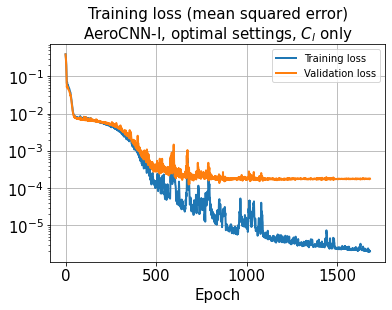

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

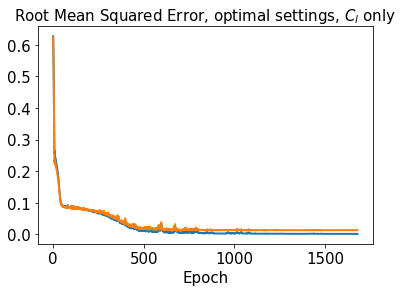

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

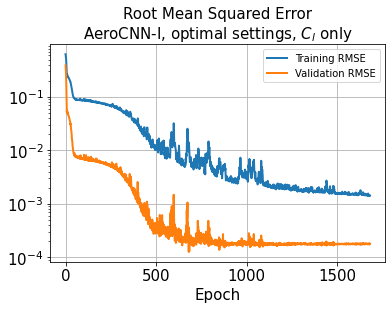

In [42]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_l$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 15ms/step - loss: 3.9142e-05 - rmse: 0.0063


In [44]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 63ms/step - loss: 5.7658e-05 - rmse: 0.0076


In [45]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 15ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cl, y_train)))
index_val = np.unique(np.where(np.isin(cl, y_val)))
index_test = np.unique(np.where(np.isin(cl, y_test)))

In [48]:
y_train = y_train*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_val = y_val*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
y_test = y_test*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_val = decoded_val_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
decoded_test = decoded_test_*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221130steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_optimalSettings_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.009560219940012951


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.01650080421614035


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.011358699095509564


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

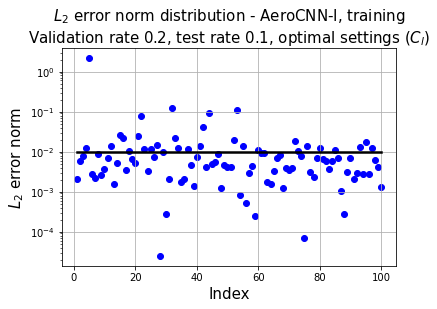

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

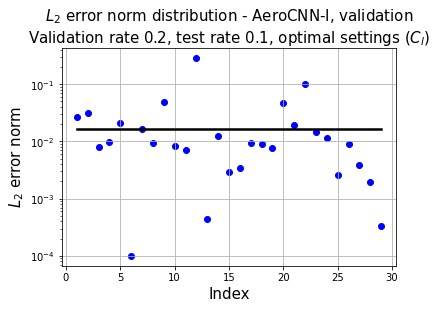

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

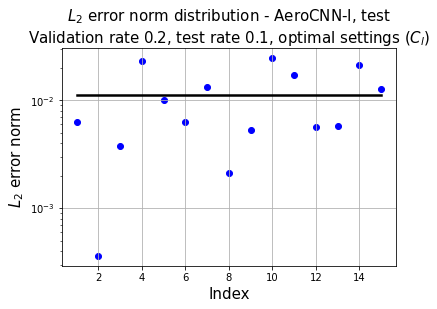

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_l$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 12ms/step


In [67]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cl = title_0_Cl
        savename2 = "ClComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cl = title_n_Cl
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    '''# CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aVal, iVal*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='g', label='Validation set')
    plt.scatter(aTest, iTest*(np.max(cd_orig)-np.max(cd_orig))+np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

   # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 16ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cl: 0.0147


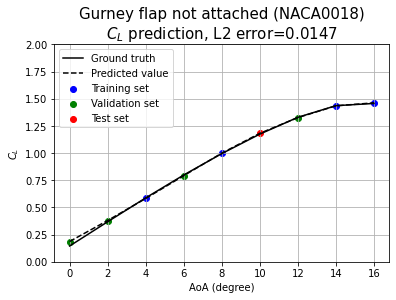

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0111


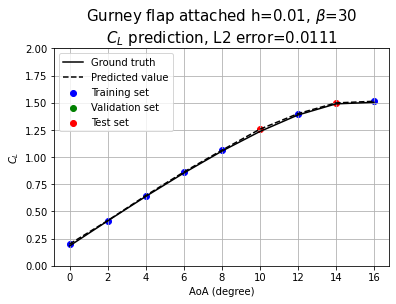

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0037


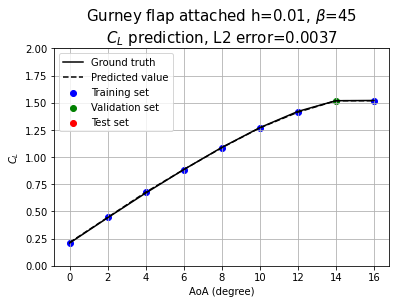

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0050


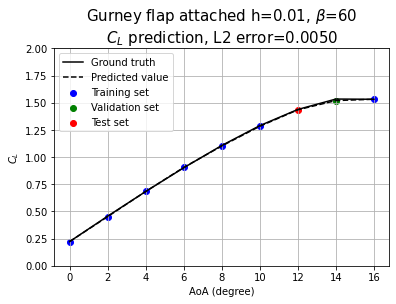

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0133


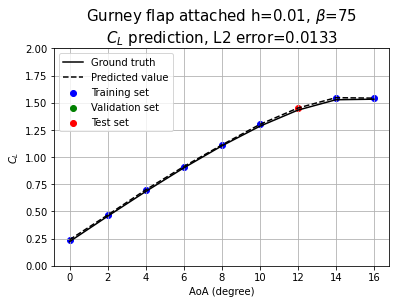

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0088


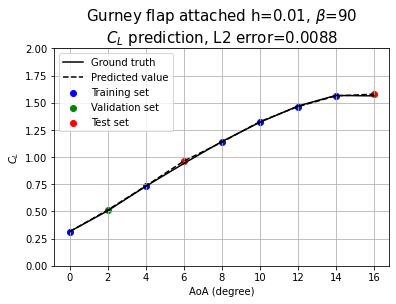

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0058


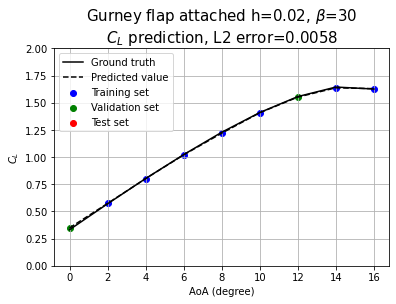

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0078


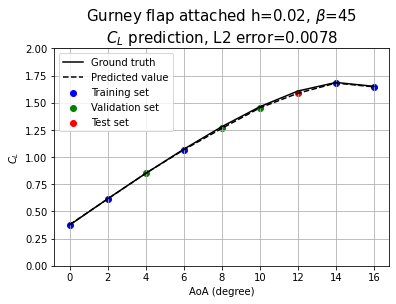

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0085


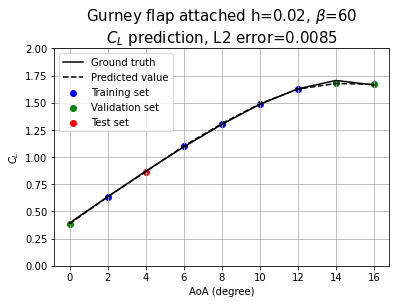

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0049


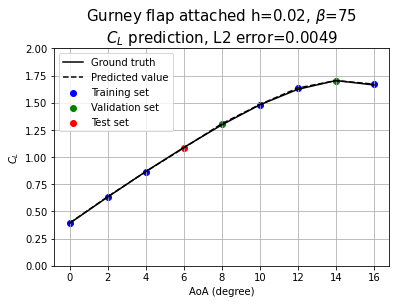

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0114


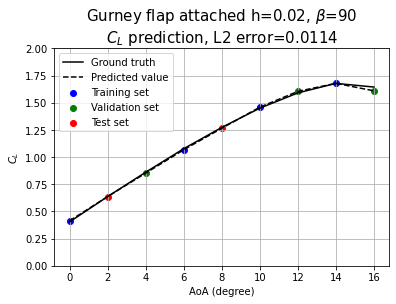

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0092


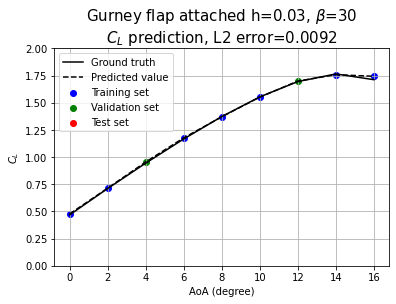

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0070


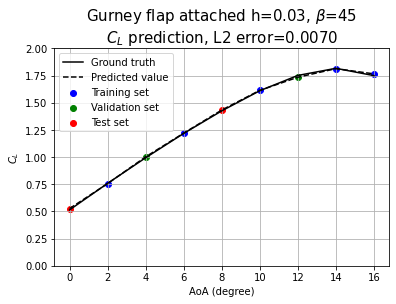

1/1 [==============================] - 0s 16ms/step
L2 error of Cl: 0.0093


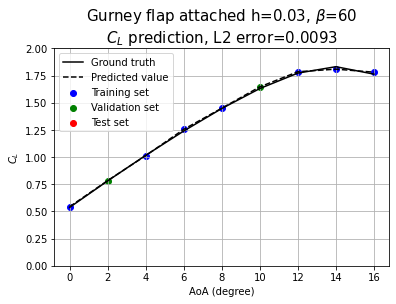

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0142


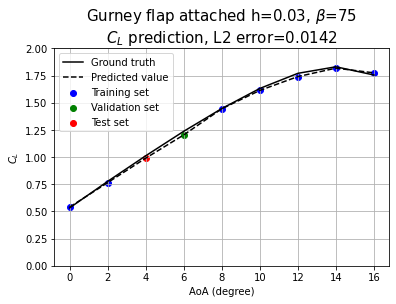

1/1 [==============================] - 0s 15ms/step
L2 error of Cl: 0.0439


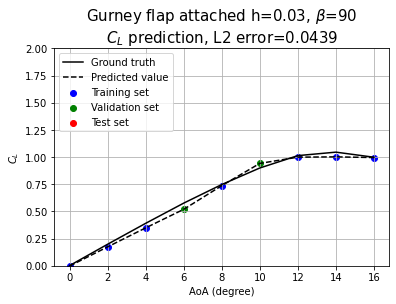

In [69]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:], x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cl: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    CL = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iTest = np.array(iTest)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    iVal = np.array(iVal)*(np.max(cl_orig)-np.min(cl_orig))+np.min(cl_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CL_trainTestSplit_Plot(i, CL, cl, aTrain, aTest, iTrain, iTest)